In [60]:
# required imports
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt

In [61]:
# randomness parameters
seed = 1234
rng = Generator(PCG64(seed=seed))

In [62]:
# simulation parameters
n = 30
servers = 1
arrival_rate = 1 / 6
service_rate = 1 / 4
arrival_distribution = rng.exponential
service_distribution = rng.exponential

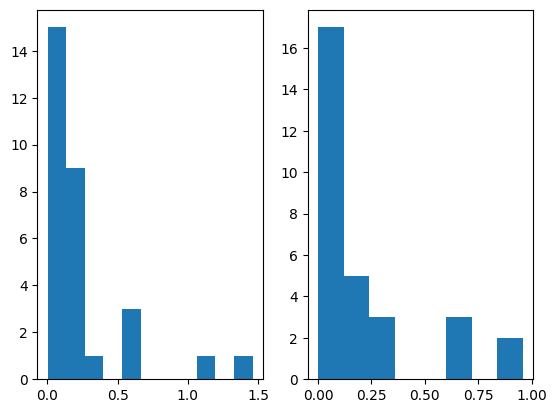

In [66]:
fig, ax = plt.subplots(1,2)
ax[0].hist(arrival_distribution(scale=arrival_rate, size=n), bins='auto') 
ax[1].hist(service_distribution(scale=service_rate, size=n), bins='auto') 
plt.show()

In [64]:
class Simulation:
    def __init__(self, n, arrival_distribution, arrival_rate, service_distribution, service_rate, precision=3):
        # distributions
        self.arrival_distribution = arrival_distribution
        self.service_distribution = service_distribution
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        
        # event_list
        self.next_arrival_time = np.inf
        self.next_departure = np.inf
        
        # system state
        self.n = n
        self.clock = 0
        self.system = []
        self.queue = []
        self.server_status = 0
        self.precision = precision
        
        # statistical counters
        self.number_served = 0
        self.total_waiting_time = 0
        self.total_system_time = 0 # delay/response time
        self.area_under_q = 0
        self.area_under_b = 0
    
    def generate_inter_arrival(self):
        return np.round(self.arrival_distribution(scale=self.arrival_rate), self.precision)
    
    def generate_service_time(self):
        return np.round(self.service_distribution(scale=self.service_rate), self.precision)
    
    def update_area_under_b(self, next_time):
        self.area_under_b += (next_time - self.clock) * self.server_status
    
    def update_area_under_q(self, next_time):
        self.area_under_q += (next_time - self.clock) * len(self.queue)
    
    def update_waiting_time(self):
        if len(self.queue) != 0:
            self.total_waiting_time += self.next_departure - self.queue[0]
        
    def update_system_time(self):
        if len(self.system) != 0:
            self.total_system_time += self.next_departure - self.system[0]
        
    def arrival_handler(self):
        self.clock = self.next_arrival_time
        self.queue.append(self.next_arrival_time)
        self.next_arrival_time = self.clock + self.generate_inter_arrival()
        
        if self.server_status == 0:
            self.server_status = 1
            self.system.append(self.queue[0])
            self.queue = self.queue[1:]
            self.next_departure = self.clock + self.generate_service_time()
    
    def departure_handler(self):
        self.clock = self.next_departure
        self.number_served += 1
        
        if len(self.queue) != 0:
            self.system[0] = self.queue[0]
            self.queue = self.queue[1:]
            self.next_departure = self.clock + self.generate_service_time()
        else:
            self.next_departure = np.inf
            self.server_status = 0
            self.system = self.system[1:]
       
    def run(self):
        self.next_arrival_time = self.generate_inter_arrival()
        while self.number_served < n:
            if self.next_arrival_time <= self.next_departure:
                self.update_area_under_b(self.next_arrival_time)
                self.update_area_under_q(self.next_arrival_time)
                self.arrival_handler()
            else:
                self.update_area_under_b(self.next_departure)
                self.update_area_under_q(self.next_departure)
                self.update_waiting_time()
                self.update_system_time()
                self.departure_handler()
            
        self.report()
        
    def report(self):
        mean_system_time = np.round(self.total_system_time / self.number_served, self.precision)
        mean_waiting_time = np.round(self.total_waiting_time / self.number_served, self.precision)
        mean_queue_length = np.round(self.area_under_q / self.clock, self.precision)
        mean_utilization = np.round(self.area_under_b / self.clock, self.precision)
        print(f'Customers served: {self.number_served}')
        print(f'Expected mean system time: {mean_system_time}')
        print(f'Expected mean waiting time: {mean_waiting_time}')
        print(f'Expected queue lenght: {mean_queue_length}')
        print(f'Expected utilisation: {mean_utilization}')

In [65]:
des = Simulation(n, arrival_distribution, arrival_rate, service_distribution, service_rate)
des.run()

Customers served: 30
Expected mean system time: 0.241
Expected mean waiting time: 0.113
Expected queue lenght: 0.55
Expected utilisation: 0.628
